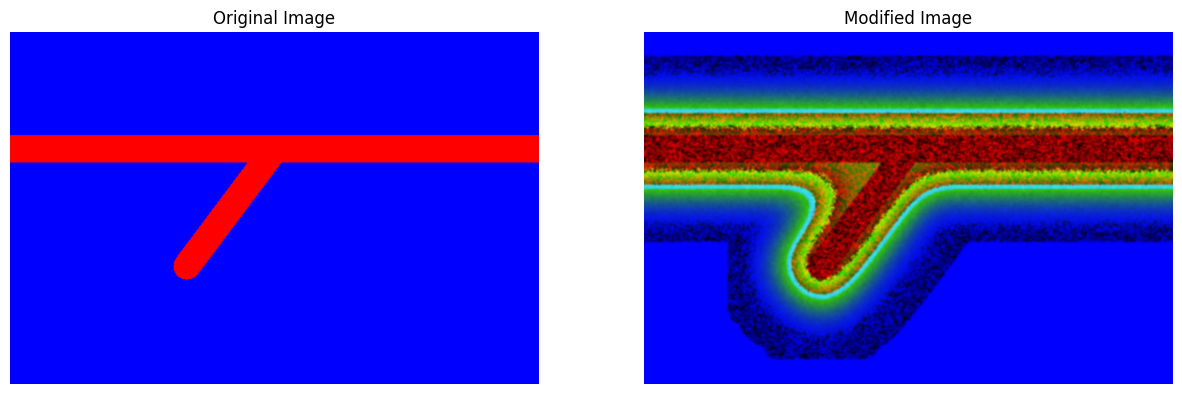

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def generate_perlin_noise(shape, scale=100, octaves=6, persistence=0.5):
    """Generate Perlin-like noise for more natural cloud patterns"""
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 5
    max_value = 0
    
    for _ in range(octaves):
        noise += amplitude * cv2.resize(np.random.rand(shape[0]//frequency, shape[1]//frequency), 
                                      (shape[1], shape[0]), 
                                      interpolation=cv2.INTER_LINEAR)
        max_value += amplitude
        amplitude *= persistence
        frequency *= 2
        
    return noise / max_value

def generate_shaped_diffusion(base_image):
    # Create a copy of the input image
    result = base_image.copy()
    
    # Extract red regions
    lower_red = np.array([0, 0, 100])
    upper_red = np.array([100, 100, 255])
    red_mask = cv2.inRange(base_image, lower_red, upper_red)
    
    # Generate shapes mask
    kernels = [
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31)),
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21)),
        cv2.getStructuringElement(cv2.MORPH_CROSS, (41, 41)),
    ]
    
    # Create base transition mask
    transition_mask = np.zeros_like(red_mask, dtype=np.float32)
    
    for kernel in kernels:
        dilated = cv2.dilate(red_mask, kernel, iterations=2)
        transition_mask += dilated.astype(np.float32)
    
    transition_mask = transition_mask / len(kernels)
    transition_mask = cv2.GaussianBlur(transition_mask, (101, 101), 20)
    
    # Generate noise for variation
    noise = generate_perlin_noise(base_image.shape[:2], scale=50)
    
    # Create color transitions
    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            if transition_mask[y, x] > 0:
                # Calculate transition factor (0 to 1)
                factor = transition_mask[y, x] / 255.0
                noise_factor = 0.8 + 0.4 * noise[y, x]
                
                # Red area
                if red_mask[y, x] > 0:
                    result[y, x] = [0, 0, int(255 * noise_factor)]
                # Transition area
                else:
                    # Create yellow-green transition
                    if factor > 0.6:
                        # Transition from red to yellow
                        yellow_factor = (factor - 0.5) * 3
                        b = 0
                        g = int(255 * yellow_factor * noise_factor)
                        r = int(255 * noise_factor)
                    else:
                        # Transition from yellow-green to blue
                        green_factor = factor * 2
                        b = int(255 * (1 - green_factor) * noise_factor)
                        g = int(200 * green_factor * noise_factor)
                        r = int(50 * green_factor * noise_factor)
                    
                    result[y, x] = [b, g, r]
    
    # Final smoothing
    result = cv2.GaussianBlur(result, (11, 11), 1)
    
    return result

# Load and process the image
image_path = r'test_image.png'
image = cv2.imread(image_path)
modified_image = generate_shaped_diffusion(image)

# Display results
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Modified Image')
plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
import torch
import numpy as np
from torchvision import transforms
from custom_transforms import  NormalizeSpectrogram, ToTensor, InterpolateSpectrogram
from SearchNet import SearchNet

def predict_single_spectrogram(spectrogram_array, DEVICE):
    # Apply transforms individually to handle the different input types
    # NormalizeSpectrogram expects numpy array
    normalize = NormalizeSpectrogram()
    normalized_spectrogram = normalize(spectrogram_array)
    
    # ToTensor expects numpy array and returns tensor
    to_tensor = ToTensor()
    tensor_spectrogram = to_tensor(normalized_spectrogram)
    
    # InterpolateSpectrogram expects tensor
    interpolate = InterpolateSpectrogram()
    interpolated_spectrogram = interpolate(tensor_spectrogram)
    
    # Add batch dimension and move to device
    input_tensor = interpolated_spectrogram.unsqueeze(0).to(DEVICE)
    # Initialize and load model
    model = SearchNet(0.10, 1.16, 0.75, 0.75).to(DEVICE)
    model.load_state_dict(torch.load("final_model_final_model"))#, map_location=torch.device('cpu')))
    model.eval()

    #Make prediction
    with torch.no_grad():
        prediction = model(input_tensor)
    
    return prediction.squeeze().cpu().numpy()

In [17]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

spectrogram_array = np.load(r"ball_hit_spectrograms.npy")

prediction = predict_single_spectrogram(spectrogram_array, DEVICE)

print(f'Predicted Radial Velocity: {prediction:.3f} m/s')

Predicted Radial Velocity: -106.574 m/s


C:\Users\szakt\AppData\Local\Temp\ipykernel_38708\1069899924.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("final_model_final_model",

# Notes

- Radial velocity is negative seeing as the ball is hit towards the radars
- This is synthetic data (image was synthesised from test_image.png) with no GT but for context, the prediction is more than what 99.999% of players are able to achieve